# Question 2: Understanding of Grid Worlds

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import random

In [2]:
x, y, z = 3, 4, 9
reward_state = (z + 1) % 3 + 1
print(f"Reward state: s{reward_state}")
p = 0.25 + 0.5 * (x + 1) / 10
print(f"Value of p: {p}")
gamma = 0.2 + 0.5 * y / 10
print(f"Value of gamma: {gamma}")

Reward state: s2
Value of p: 0.45
Value of gamma: 0.4


In [3]:
class GridWorld(object):
    def __init__(self, success_prob):
        #### Attributes defining the grid world ####
        
        # Shape of the grid world
        self.shape = (6,6)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1, 1), (2, 3), (2, 5), (3, 1), (4, 1), (4, 2), (4, 4)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(1, 2), (4, 3)]
        
        # Corresponding rewards for each of the absorbing states
        self.special_rewards = [10, -100]
        
        # Reward for all the other states
        self.default_reward = -1
        
        # Initial location
        self.initial_loc = (3, 0)
        
        # Action names
        self.action_names = ["N", "E", "S", "W"]
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        # Probabilities of the outcomes for each action
        self.action_prob = self.__generate_action_prob__(success_prob)
        
        ########################
    
        #### Internal State ####
        
        # Get attributes defining the world
        state_size, T, R, absorbing, locs, neighbours = self.__build_grid_world__()
        
        # Number of valid states in the grid world (there are 29 of them)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T
        
        # Reward function (3D tensor)
        self.R = R
        
        # Absorbing states
        self.absorbing = absorbing

        # Non-absorbing states
        self.non_absorbing = list(filter(lambda state: state not in self.absorbing, range(self.state_size)))
        
        # The locations of the valid states
        self.locs = locs

        # The neighbouring states in each direction for each state
        self.neighbours = neighbours
        
        # State number of the initial state
        self.initial_state = self.__loc_to_state__(locs, self.initial_loc);
        
        # Locating the initial state
        self.initial = np.zeros(len(locs))
        self.initial[self.initial_state] = 1
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob] = 1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, reward in enumerate(self.absorbing_locs):
            self.rewarders[reward] = self.special_rewards[i]
        
        
    ##########################
    
    #### Internal Helper Functions ####
    
    def __generate_action_prob__(self, success_prob):
        # Calculate the probability of each outcome that isn't the action we chose
        noise = (1 - success_prob) / (self.action_size - 1)

        # Fill the action-outcome matrix with noise except along the diagonal, which should be
        # our probability of successfully performing the action we chose
        action_prob = np.full((self.action_size, self.action_size), noise)
        np.fill_diagonal(action_prob, success_prob)

        return action_prob
        
        
    def __build_grid_world__(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of bools with True in the absorbing states)
        locations, neighbours, absorbing = self.__get_topology__()
        
        # Get the number of states
        S = len(locations)
        
        # Build the transition matrix
        T = np.zeros((S, S, self.action_size))
        for action, outcomes in enumerate(self.action_prob):
            for outcome, prob in enumerate(outcomes):
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    T[post_state, prior_state, action] += prob
    
        # Build the reward matrix
        R = self.default_reward * np.ones((S, S, self.action_size))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.__loc_to_state__(locations, self.absorbing_locs[i])
            R[post_state, :, :] = sr
        
        return S, T, R, absorbing, locations, neighbours
    
    
    def __get_topology__(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the location of each state
                loc = (i, j)
                
                # And append it to the valid state locations if it is a valid state (ie. not absorbing)
                if self.__is_valid_location__(loc):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.__get_neighbour__(loc,direction) for direction in self.action_names]
                    neighbour_locs.append(local_neighbours)
                
        # Translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states, self.action_size), dtype=int)
        
        for state in range(num_states):
            for direction in range(self.action_size):
                # Turn neighbour location into a state number and insert it into neighbour matrix
                state_neighbours[state, direction] = self.__loc_to_state__(locs, neighbour_locs[state][direction])
    
        # Translate absorbing locations into absorbing state indices
        absorbing = list(map(lambda loc: self.__loc_to_state__(locs, loc), self.absorbing_locs))
        
        return locs, state_neighbours, absorbing 


    def __loc_to_state__(self, locs, loc):
        # Takes list of locations and gives index corresponding to input location
        return locs.index(tuple(loc))


    def __is_valid_location__(self, loc):
        # It is a valid location if it is within grid shape and not an obstacle
        if loc[0] < 0 or loc[1] < 0 or loc[0] > self.shape[0] - 1 or loc[1] > self.shape[1] - 1:
            return False
        elif loc in self.obstacle_locs:
            return False
    
        return True
    

    def __get_neighbour__(self, loc, direction):
        # Find valid neighbours that are in the grid and not an obstacle
        i = loc[0]
        j = loc[1]
        
        north = (i - 1, j)
        east = (i, j + 1)
        south = (i + 1, j)
        west = (i, j - 1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if direction == "N" and self.__is_valid_location__(north):
            return north
        elif direction == "E" and self.__is_valid_location__(east):
            return east
        elif direction == "S" and self.__is_valid_location__(south):
            return south
        elif direction == "W" and self.__is_valid_location__(west):
            return west

        # Default is to return to the same location
        return loc


    def __get_optimal_action__(self, Q):
        # Choose the optimal action that maxes Q for a given state
        optimal_actions = np.argwhere(Q == np.max(Q)).flatten()

        # If more than one action is optimal, randomly pick one
        if len(optimal_actions) > 1:
            optimal_action = random.choice(optimal_actions)
        else:
            optimal_action = optimal_actions[0]

        return optimal_action


    def __epsilon_greedy__(self, policy, epsilon, Q):
        # Calculate the probability that we chose a random action to explore
        explore_prob = epsilon / policy.shape[1]

        # Set our policy to this probability across the policy
        epsilon_greedy_policy = np.full(policy.shape, explore_prob)

        # For each state in the policy
        for state in range(policy.shape[0]):
            # Choose the optimal action for the state based on Q
            optimal_action = self.__get_optimal_action__(Q[state])

            # Set the probability of our optimal action to be epsilon-greedy
            epsilon_greedy_policy[state, optimal_action] += 1 - epsilon

        return epsilon_greedy_policy


    # Generate an episode trace using exploring starts
    def __generate_episode__(self, policy):
        # Randomize the initial state from our non-absorbing states
        current_state = random.choice(self.non_absorbing)

        # Collect tuples of (state, action, reward) representing the trace for the episode
        episode = []

        # Until we reach an absorbing state
        while current_state not in self.absorbing:
            # Choose an action for the current state, given by our policy
            actions = policy[current_state]
            action = random.choice(len(actions), p=actions)

            # Randomize the outcome using our action-outcome matrix
            outcomes = self.action_prob[action]
            outcome = random.choice(len(outcomes), p=outcomes)

            # Find the successor state and determine our reward
            successor_state = self.neighbours[current_state, outcome]
            reward = self.R[successor_state, current_state, action]
            
            # Append the (state, action, reward) tuple to the episode
            episode.append((current_state, action, reward))

            # Repeat for the successor state
            current_state = successor_state
        
        # Append the terminal state to the episode without an action or reward
        episode.append((current_state, 0, 0))

        return episode


    ########################
    
    #### Methods ####

    def display(self):
        plt.figure()
        plt.subplot(1 ,3, 1)
        plt.imshow(self.walls)
        plt.subplot(1, 3, 2)
        plt.imshow(self.absorbers)
        plt.subplot(1, 3, 3)
        plt.imshow(self.rewarders)
        plt.show()

    
    def draw_deterministic_policy(self, policy):
        # Draw a deterministic policy
        # The policy needs to be a numpy array of 29 values between 0 and 3 (0 -> N, 1 -> E, 2 -> S, 3 -> W)
        plt.figure()
        
        plt.imshow(self.walls + self.rewarders + self.absorbers)
        for state, action in enumerate(policy):
            if state not in self.absorbing:
                arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
                action_arrow = arrows[np.argmax(action)]
                location = self.locs[state]
                plt.text(location[1], location[0], action_arrow, ha="center", va="center") # Place it on graph
    
        plt.show()

    
    def display_value_function(self, value):
        # Draw the given value function
        # The value needs to be a numpy array of 29 values
        plt.figure()
        plt.imshow(self.walls + self.rewarders + self.absorbers)
        
        for state, v in enumerate(value):
            if state not in self.absorbing:
                location = self.locs[state]
                plt.text(location[1], location[0], round(v, 3), ha="center", va="center")
    
        plt.show()


    def value_iteration(self, gamma, threshold):
        # Get the transition and reward matrices
        T = self.T
        R = self.R
        
        epochs = 0
        delta = threshold # Set the value of delta as our stopping condition
        V = np.zeros(self.state_size) # Initialise value for each state to 0

        while delta >= threshold:
            epochs += 1
            delta = 0 # Reinitialise delta value

            # For each state
            for state in range(self.state_size):
                # If not an absorbing state
                if state not in self.absorbing:
                    # Store the previous value for that state
                    V_prev = V[state] 

                    # Compute Q value
                    Q = np.zeros(self.action_size) # Initialise with value 0
                    for successor_state in range(self.state_size):
                        Q += T[successor_state, state, :] * (R[successor_state, state, :] + gamma * V[successor_state])
                
                    # Set the new value to the maximum of Q
                    V[state] = np.max(Q) 

                    # Compute the new delta
                    delta = max(delta, np.abs(V_prev - V[state]))

        # When the loop is finished, fill in the optimal policy
        optimal_policy = np.zeros((self.state_size, self.action_size))

        # For each state
        for state in range(self.state_size):

            # Compute Q value
            Q = np.zeros(self.action_size)
            for successor_state in range(self.state_size):
                Q += T[successor_state, state, :] * (R[successor_state, state, :] + gamma * V[successor_state])
            
            # The action that maximises the Q value gets probability 1
            optimal_action = self.__get_optimal_action__(Q)
            optimal_policy[state, optimal_action] = 1 

        return optimal_policy, V, epochs


    def monte_carlo_iterative_optimisation(self, policy, episodes, epsilon, gamma, alpha):
        Q = np.zeros((self.state_size, self.action_size)) # Initialise value for each state-action to 0
        policy = self.__epsilon_greedy__(policy, epsilon, Q) # Use an epsilon-greedy policy based on Q
        optimal_value = np.zeros(self.state_size) # Initialise optimal value for each state to 0

        # Collect the cumulative rewards and optimal value function from each episode
        episode_rewards = np.zeros(episodes)
        episode_values = np.zeros((episodes, self.state_size))
        
        # For each episode
        for i in range(episodes):
            # Generate a random episode based on our policy and reverse it to facilitate computation
            # of total discounted return in each state along the trace
            trace = self.__generate_episode__(policy)
            trace.reverse()

            R = 0
            R_first = {} # Dictionary for holding the first-visit returns for each state in the trace
            for idx, transition in enumerate(trace[1:]):
                # Compute the total discounted return for each state and store it
                state, action, reward = transition
                R = gamma * R + reward
                R_first[(state, action)] = R

                # Calculate the cumulative rewards collected along the episode
                episode_rewards[i] += reward

            # For each transition in the trace
            for transition in trace[1:]:
                # Update our Q value of the state-action using the first-visit return we sampled
                state, action = transition[0], transition[1]
                Q[state, action] += alpha * (R_first[(state, action)] - Q[state, action])

            # Update our epsilon-greedy policy using the updated Q
            policy = self.__epsilon_greedy__(policy, epsilon, Q)
            
            # Calculate optimal V using the max Q for each state
            for state in range(self.state_size):
                optimal_value[state] = np.max(Q[state])
            
            episode_values[i] = optimal_value

        # After all episodes, fill in our optimal policy
        optimal_policy = np.zeros((self.state_size, self.action_size))

        for state in range(self.state_size):
            # The action that maximises the Q value gets probability 1
            optimal_action = self.__get_optimal_action__(Q[state])
            optimal_policy[state, optimal_action] = 1

        return optimal_policy, optimal_value, episode_rewards, episode_values

    def q_learning(self, episodes, epsilon, gamma, alpha):
        Q = np.zeros((self.state_size, self.action_size)) # Initialise value for each state-action to 0
        optimal_value = np.zeros(self.state_size) # Initialise optimal value for each state to 0

        # Collect the cumulative rewards and optimal value function from each episode
        episode_rewards = np.zeros(episodes)
        episode_values = np.zeros((episodes, self.state_size))

        # For each episode
        for i in range(episodes):
            # Randomize the initial state from our non-absorbing states
            current_state = random.choice(self.non_absorbing)

            # Until we reach an absorbing state
            while current_state not in self.absorbing:
                # Choose the optimal action for current state based on Q
                optimal_action = self.__get_optimal_action__(Q[current_state])

                # Calculate the probability that we chose a random action to explore
                explore_prob = epsilon / self.action_size
                
                # Set an epsilon-greedy policy to choose the next action
                epsilon_greedy_policy = np.full(self.action_size, explore_prob)
                epsilon_greedy_policy[optimal_action] += 1 - epsilon

                # Choose a random action using our epsilon-greedy policy
                action = random.choice(self.action_size, p=epsilon_greedy_policy)

                # Randomize the outcome using our action-outcome matrix
                outcomes = self.action_prob[action]
                outcome = random.choice(len(outcomes), p=outcomes)

                # Find the successor state and determine our reward
                successor_state = self.neighbours[current_state, outcome]
                reward = self.R[successor_state, current_state, action]

                # Update our Q value using the reward and the successor state-action's discounted Q value
                Q[current_state, action] += alpha * (reward + gamma * np.max(Q[successor_state]) - Q[current_state, action])

                # Repeat for the successor state
                current_state = successor_state

                # Calculate the cumulative rewards collected along the episode
                episode_rewards[i] += reward

                # Calculate optimal V using the max Q for each state
                for state in range(self.state_size):
                    optimal_value[state] = np.max(Q[state])
                
                episode_values[i] = optimal_value

        # After all episodes, fill in our optimal policy
        optimal_policy = np.zeros((self.state_size, self.action_size))

        for state in range(self.state_size):
            # The action that maximises the Q value gets probability 1
            optimal_action = self.__get_optimal_action__(Q[state])
            optimal_policy[state, optimal_action] = 1

        return optimal_policy, optimal_value, episode_rewards, episode_values

# Question 2b (Dynamic Programming)

Creating the Grid World for p = 0.45, represented as: 



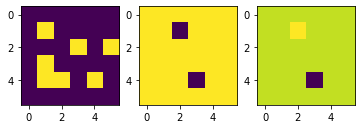


Optimal value function computed using value iteration, after 12 epochs:



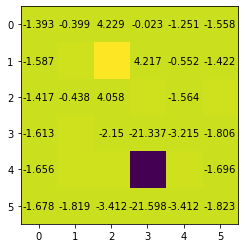


Optimal policy computed using value iteration, after 12 epochs:



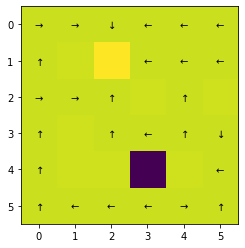

In [4]:
grid = GridWorld(p)
print(f"Creating the Grid World for p = {p}, represented as: \n")
grid.display()
print()

threshold = 0.00001

dp_optimal_policy, dp_optimal_value, epochs = grid.value_iteration(gamma, threshold)

print(f"Optimal value function computed using value iteration, after {epochs} epochs:\n")
grid.display_value_function(dp_optimal_value)
print()

print(f"Optimal policy computed using value iteration, after {epochs} epochs:\n")
grid.draw_deterministic_policy(dp_optimal_policy)
print()

For p = 0.1, gamma = 0.4:

Optimal value function computed using value iteration, after 12 epochs:



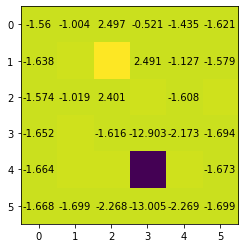


Optimal policy computed using value iteration, after 12 epochs:



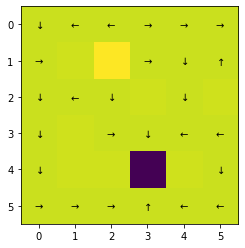


For p = 0.25, gamma = 0.4:

Optimal value function computed using value iteration, after 13 epochs:



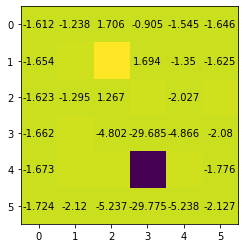


Optimal policy computed using value iteration, after 13 epochs:



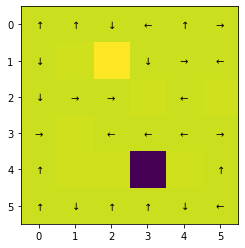


For p = 0.9, gamma = 0.4:

Optimal value function computed using value iteration, after 9 epochs:



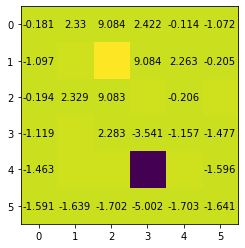


Optimal policy computed using value iteration, after 9 epochs:



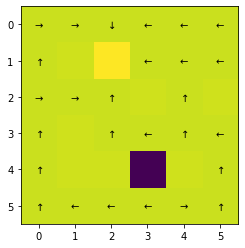


For p = 0.45, gamma = 0.25:

Optimal value function computed using value iteration, after 9 epochs:



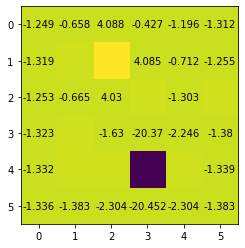


Optimal policy computed using value iteration, after 9 epochs:



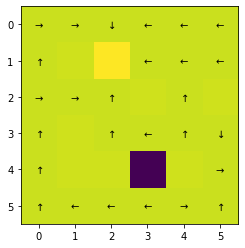


For p = 0.45, gamma = 0.75:

Optimal value function computed using value iteration, after 31 epochs:



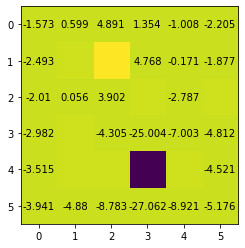


Optimal policy computed using value iteration, after 31 epochs:



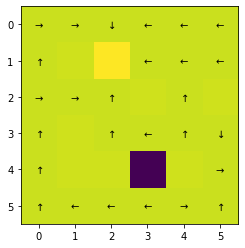

In [5]:
# Investigate how the value of p affects our optimal value function and policy
p_values = [0.1, 0.25, 0.9]

for test_p in p_values:
    test_grid = GridWorld(test_p)

    print(f"For p = {test_p}, gamma = {gamma}:\n")
    dp_optimal_policy, dp_optimal_value, epochs = test_grid.value_iteration(gamma, threshold)

    print(f"Optimal value function computed using value iteration, after {epochs} epochs:\n")
    test_grid.display_value_function(dp_optimal_value)
    print()

    print(f"Optimal policy computed using value iteration, after {epochs} epochs:\n")
    test_grid.draw_deterministic_policy(dp_optimal_policy)
    print()

# Investigate how the value of gamma affects our optimal value function and policy
gamma_values = [0.25, 0.75]

for test_gamma in gamma_values:
    test_grid = GridWorld(p)

    print(f"For p = {p}, gamma = {test_gamma}:\n")
    dp_optimal_policy, dp_optimal_value, epochs = test_grid.value_iteration(test_gamma, threshold)

    print(f"Optimal value function computed using value iteration, after {epochs} epochs:\n")
    test_grid.display_value_function(dp_optimal_value)
    print()

    print(f"Optimal policy computed using value iteration, after {epochs} epochs:\n")
    test_grid.draw_deterministic_policy(dp_optimal_policy)
    print()

# Question 2c (Monte Carlo RL)

Creating the Grid World for p = 0.45, represented as: 



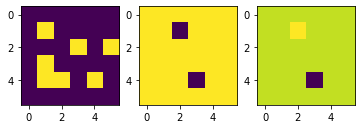


Starting from a uniform policy with epsilon = 0.1, alpha = 0.05:

Optimal value function computed using Monte Carlo iterative optimisation, over 1000 episodes:



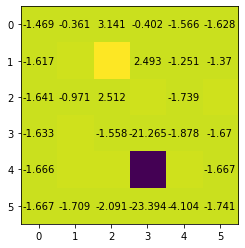


Optimal policy computed using Monte Carlo iterative optimisation over, 1000 episodes:



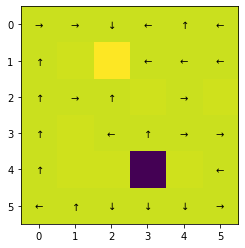

In [6]:
grid = GridWorld(p)
print(f"Creating the Grid World for p = {p}, represented as: \n")
grid.display()
print()

episodes = 1000
epsilon = 0.1
alpha = 0.05

# Initialise an initial unbiased policy
policy = np.full((grid.state_size, grid.action_size), 1 / grid.action_size)
print(f"Starting from a uniform policy with epsilon = {epsilon}, alpha = {alpha}:\n")

mc_optimal_policy, mc_optimal_value, mc_episode_rewards, mc_episode_values = grid.monte_carlo_iterative_optimisation(policy, episodes, epsilon, gamma, alpha)

print(f"Optimal value function computed using Monte Carlo iterative optimisation, over {episodes} episodes:\n")
grid.display_value_function(mc_optimal_value)
print()

print(f"Optimal policy computed using Monte Carlo iterative optimisation over, {episodes} episodes:\n")
test_grid.draw_deterministic_policy(mc_optimal_policy)
print()

Learning curve obtained over 100 repetitions of 1000 episodes:



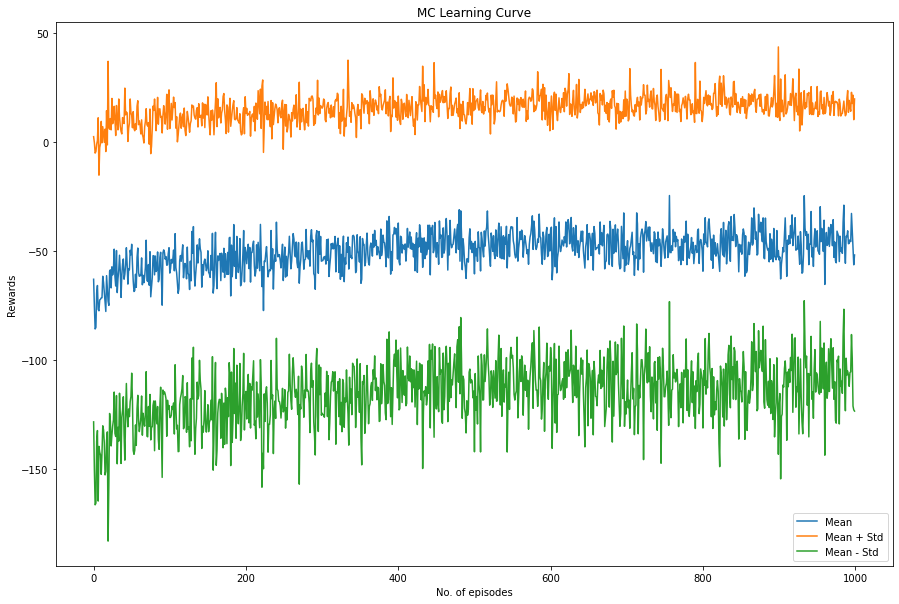

In [7]:
repetitions = 100
mc_learning_curves = np.zeros((repetitions, episodes))
mc_episode_values = np.zeros((repetitions, episodes, grid.state_size))

print(f"Learning curve obtained over {repetitions} repetitions of {episodes} episodes:\n")

# Repeat MC iterative optimisation to get a better estimate of our agent's learning curve
for i in range(repetitions):
    _, _, episode_rewards, episode_values = grid.monte_carlo_iterative_optimisation(policy, episodes, epsilon, gamma, alpha)
    mc_learning_curves[i] = episode_rewards
    mc_episode_values[i] = episode_values

# Determine the mean learning curve 
mc_mean_learning_curve = np.mean(mc_learning_curves, axis=0)

# Determine the standard deviation of rewards
mc_std_learning_curve = np.std(mc_learning_curves, axis=0)

plt.figure(figsize=(15, 10))
plt.xlabel("No. of episodes")
plt.ylabel("Rewards")
plt.title("MC Learning Curve")

plt.plot(mc_mean_learning_curve, label="Mean")
plt.plot(mc_mean_learning_curve + mc_std_learning_curve, label="Mean + Std")
plt.plot(mc_mean_learning_curve - mc_std_learning_curve, label="Mean - Std")
plt.legend()

plt.savefig("figures/2c3.png")
plt.show()

Investigating the effect of epsilon on the learning curve:



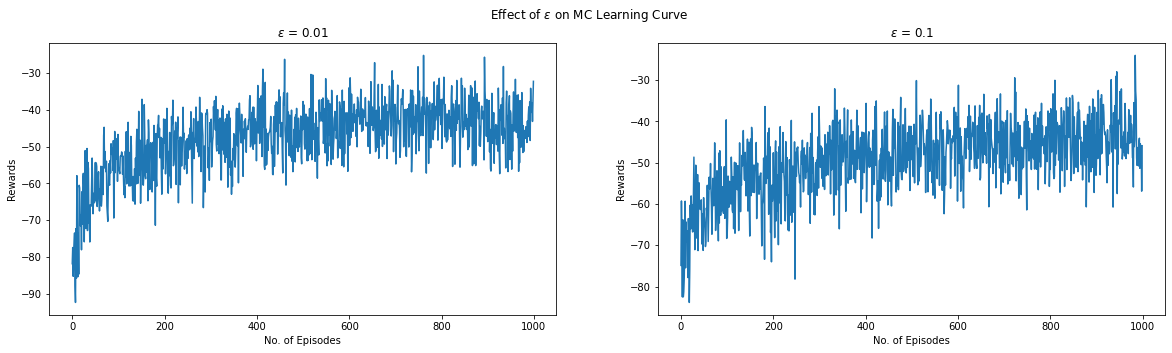


Investigating the effect of alpha on the learning curve:



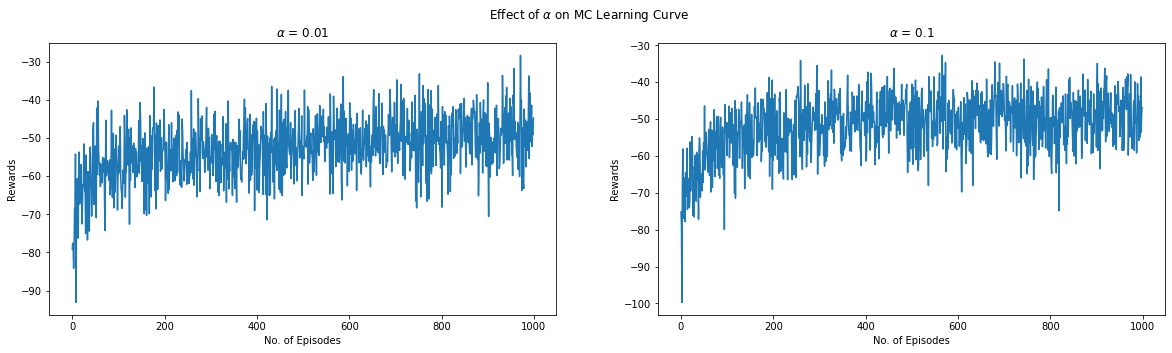

In [8]:
# Investigate how the value of epsilon affects our agent's learning curve
epsilon_values = [0.01, 0.1]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(r"Effect of $\epsilon$ on MC Learning Curve")

print("Investigating the effect of epsilon on the learning curve:\n")

for idx, test_epsilon in enumerate(epsilon_values):
    learning_curves = np.zeros((repetitions, episodes))

    for i in range(repetitions):
        _, _, episode_rewards, _ = grid.monte_carlo_iterative_optimisation(policy, episodes, test_epsilon, gamma, alpha)
        learning_curves[i] = episode_rewards

    mean_learning_curve = np.mean(learning_curves, axis=0)

    subplot = ax[idx]
    subplot.set(title=fr"$\epsilon$ = {test_epsilon}", xlabel="No. of Episodes", ylabel="Rewards")
    subplot.plot(mean_learning_curve)

plt.savefig("figures/2c4_epsilon.png")
plt.show()
print()

# Investigate how the value of alpha affects our agent's learning curve
alpha_values = [0.01, 0.1]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(r"Effect of $\alpha$ on MC Learning Curve")

print("Investigating the effect of alpha on the learning curve:\n")

for idx, test_alpha in enumerate(alpha_values):
    learning_curves = np.zeros((repetitions, episodes))

    for i in range(repetitions):
        _, _, episode_rewards, _ = grid.monte_carlo_iterative_optimisation(policy, episodes, epsilon, gamma, test_alpha)
        learning_curves[i] = episode_rewards

    mean_learning_curve = np.mean(learning_curves, axis=0)

    subplot = ax[idx]
    subplot.set(title=fr"$\alpha$ = {test_alpha}", xlabel="No. of Episodes", ylabel="Rewards")
    subplot.plot(mean_learning_curve)

plt.savefig("figures/2c4_alpha.png")
plt.show()
print()

# Question 2d (Temporal Difference RL)

Creating the Grid World for p = 0.45, represented as: 



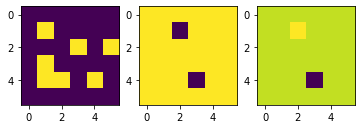


Optimal value function computed using Q-Learning, over 1000 episodes:



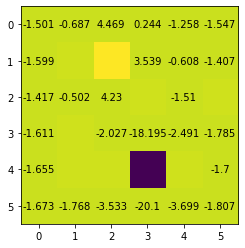


Optimal policy computed using Q-Learning, over 1000 episodes:



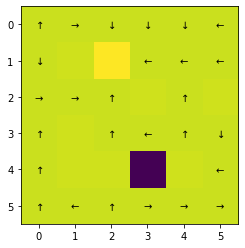

In [9]:
grid = GridWorld(p)
print(f"Creating the Grid World for p = {p}, represented as: \n")
grid.display()
print()

episodes = 1000
epsilon = 0.1
alpha = 0.05

td_optimal_policy, td_optimal_value, td_episode_rewards, td_episode_values = grid.q_learning(episodes, epsilon, gamma, alpha)

print(f"Optimal value function computed using Q-Learning, over {episodes} episodes:\n")
grid.display_value_function(td_optimal_value)
print()

print(f"Optimal policy computed using Q-Learning, over {episodes} episodes:\n")
test_grid.draw_deterministic_policy(td_optimal_policy)
print()

Learning curve obtained over 100 repetitions of 1000 episodes:



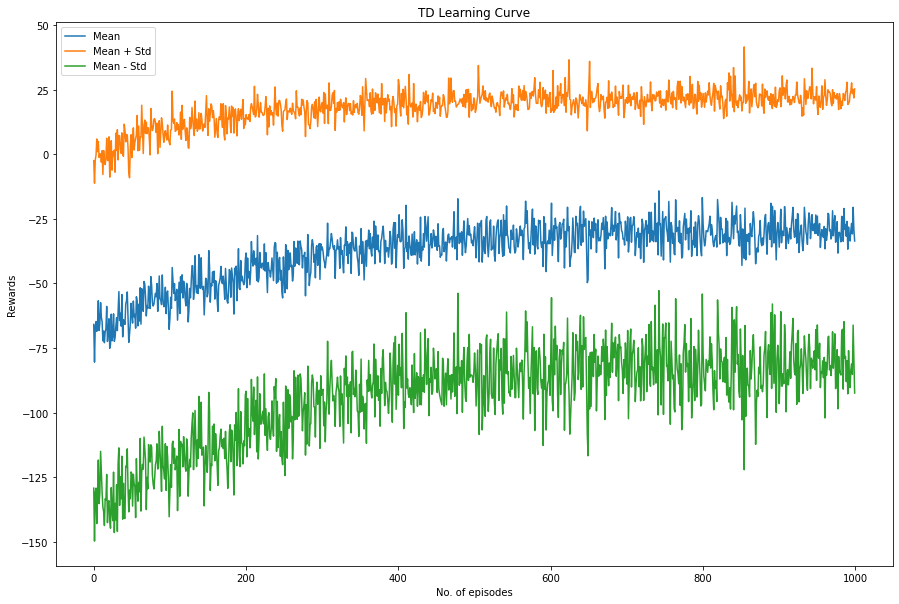

In [10]:
repetitions = 100
td_learning_curves = np.zeros((repetitions, episodes))
td_episode_values = np.zeros((repetitions, episodes, grid.state_size))

print(f"Learning curve obtained over {repetitions} repetitions of {episodes} episodes:\n")

# Repeat Q-Learning to get a better estimate of our agent's learning curve
for i in range(repetitions):
    _, _, episode_rewards, episode_values = grid.q_learning(episodes, epsilon, gamma, alpha)
    td_learning_curves[i] = episode_rewards
    td_episode_values[i] = episode_values

# Determine the mean learning curve 
td_mean_learning_curve = np.mean(td_learning_curves, axis=0)

# Determine the standard deviation of rewards
td_std_learning_curve = np.std(td_learning_curves, axis=0)

plt.figure(figsize=(15, 10))
plt.xlabel("No. of episodes")
plt.ylabel("Rewards")
plt.title("TD Learning Curve")

plt.plot(td_mean_learning_curve, label="Mean")
plt.plot(td_mean_learning_curve + td_std_learning_curve, label="Mean + Std")
plt.plot(td_mean_learning_curve - td_std_learning_curve, label="Mean - Std")
plt.legend()

plt.savefig("figures/2d3.png")
plt.show()

Investigating the effect of epsilon on the learning curve:



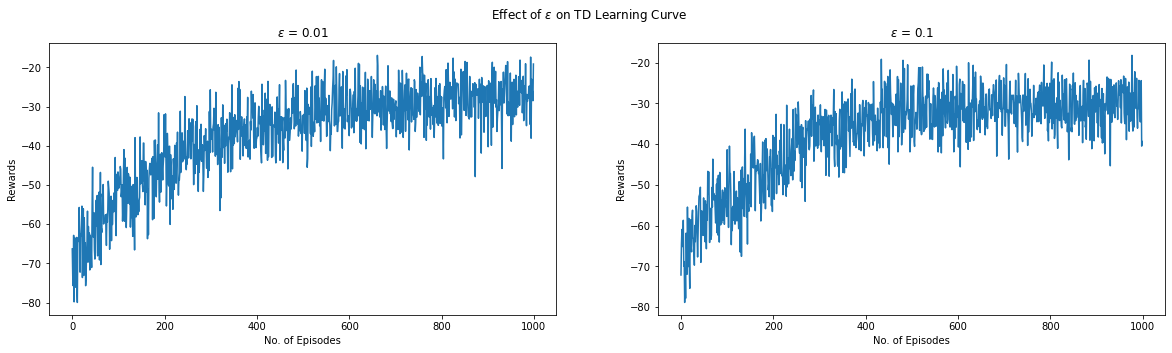


Investigating the effect of alpha on the learning curve:



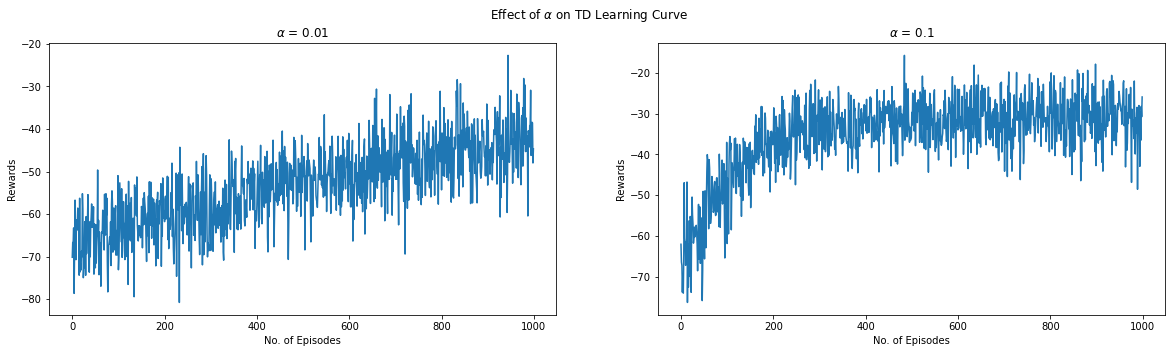

In [11]:
# Investigate how the value of epsilon affects our agent's learning curve
epsilon_values = [0.01, 0.1]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(r"Effect of $\epsilon$ on TD Learning Curve")

print("Investigating the effect of epsilon on the learning curve:\n")

for idx, test_epsilon in enumerate(epsilon_values):
    learning_curves = np.zeros((repetitions, episodes))

    for i in range(repetitions):
        _, _, episode_rewards, _ = grid.q_learning(episodes, test_epsilon, gamma, alpha)
        learning_curves[i] = episode_rewards

    mean_learning_curve = np.mean(learning_curves, axis=0)

    subplot = ax[idx]
    subplot.set(title=fr"$\epsilon$ = {test_epsilon}", xlabel="No. of Episodes", ylabel="Rewards")
    subplot.plot(mean_learning_curve)

plt.savefig("figures/2d4_epsilon.png")
plt.show()
print()

# Investigate how the value of alpha affects our agent's learning curve
alpha_values = [0.01, 0.1]

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(r"Effect of $\alpha$ on TD Learning Curve")

print("Investigating the effect of alpha on the learning curve:\n")

for idx, test_alpha in enumerate(alpha_values):
    learning_curves = np.zeros((repetitions, episodes))

    for i in range(repetitions):
        _, _, episode_rewards, _ = grid.q_learning(episodes, epsilon, gamma, test_alpha)
        learning_curves[i] = episode_rewards

    mean_learning_curve = np.mean(learning_curves, axis=0)

    subplot = ax[idx]
    subplot.set(title=fr"$\alpha$ = {test_alpha}", xlabel="No. of Episodes", ylabel="Rewards")
    subplot.plot(mean_learning_curve)

plt.savefig("figures/2d4_alpha.png")
plt.show()
print()

# Question 2e (Comparison of Learners)

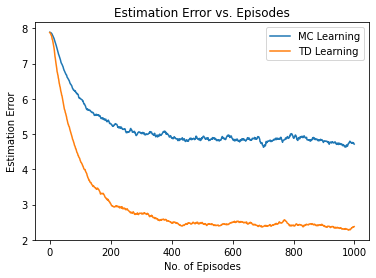

In [12]:
def rms(array):
    return np.sqrt(np.mean(array ** 2))

mc_optimal_values = np.mean(mc_episode_values, axis=0)
td_optimal_values = np.mean(td_episode_values, axis=0)

# Compute the RMS error between the optimal value function and the MC / TD estimates
mc_mean_error = np.zeros(episodes)
td_mean_error = np.zeros(episodes)

for i in range(episodes):
    mc_mean_error[i] = rms(dp_optimal_value - mc_optimal_values[i])
    td_mean_error[i] = rms(dp_optimal_value - td_optimal_values[i])

plt.figure()
plt.title("Estimation Error vs. Episodes")
plt.xlabel("No. of Episodes")
plt.ylabel("Estimation Error")

plt.plot(mc_mean_error, label="MC Learning")
plt.plot(td_mean_error, label="TD Learning")
plt.legend()

plt.savefig("figures/2e1.png")
plt.show()

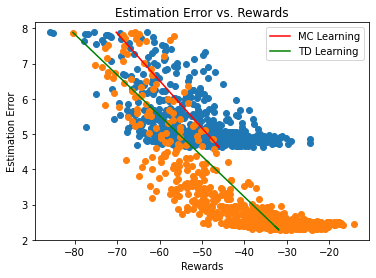

In [13]:
mc_m, mc_c = np.polyfit(mc_mean_error, mc_mean_learning_curve, 1)
td_m, td_c = np.polyfit(td_mean_error, td_mean_learning_curve, 1)

plt.figure()
plt.title("Estimation Error vs. Rewards")
plt.xlabel("Rewards")
plt.ylabel("Estimation Error")

plt.scatter(mc_mean_learning_curve, mc_mean_error)
plt.scatter(td_mean_learning_curve, td_mean_error)
plt.plot(mc_m * mc_mean_error + mc_c, mc_mean_error, "r", label="MC Learning")
plt.plot(td_m * td_mean_error + td_c, td_mean_error, "g", label="TD Learning")
plt.legend()

plt.savefig("figures/2e2.png")
plt.show()

Investigating the effect of epsilon on the estimation error over episodes:



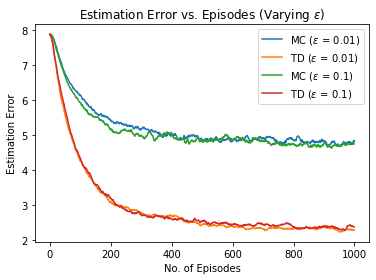


Investigating the effect of alpha on the estimation error over episodes:



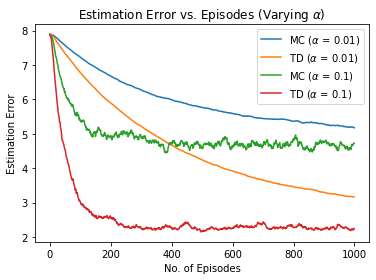

In [14]:
plt.figure()
plt.title(r"Estimation Error vs. Episodes (Varying $\epsilon$)")
plt.xlabel("No. of Episodes")
plt.ylabel("Estimation Error")

print("Investigating the effect of epsilon on the estimation error over episodes:\n")

for test_epsilon in epsilon_values:
    mc_episode_values = np.zeros((repetitions, episodes, grid.state_size))
    td_episode_values = np.zeros((repetitions, episodes, grid.state_size))

    for i in range(repetitions):
        _, _, _, mc_episode_values[i] = grid.monte_carlo_iterative_optimisation(policy, episodes, test_epsilon, gamma, alpha)
        _, _, _, td_episode_values[i] = grid.q_learning(episodes, test_epsilon, gamma, alpha)

    mc_optimal_values = np.mean(mc_episode_values, axis=0)
    td_optimal_values = np.mean(td_episode_values, axis=0)

    # Compute the RMS error between the optimal value function and the MC / TD estimates
    mc_mean_error = np.zeros(episodes)
    td_mean_error = np.zeros(episodes)

    for i in range(episodes):
        mc_mean_error[i] = rms(dp_optimal_value - mc_optimal_values[i])
        td_mean_error[i] = rms(dp_optimal_value - td_optimal_values[i])

    plt.plot(mc_mean_error, label=fr"MC ($\epsilon$ = {test_epsilon})")
    plt.plot(td_mean_error, label=fr"TD ($\epsilon$ = {test_epsilon})")

plt.legend()
plt.savefig("figures/2e3_epsilon.png")
plt.show()
print()

plt.figure()
plt.title(r"Estimation Error vs. Episodes (Varying $\alpha$)")
plt.xlabel("No. of Episodes")
plt.ylabel("Estimation Error")

print("Investigating the effect of alpha on the estimation error over episodes:\n")

for test_alpha in alpha_values:
    mc_episode_values = np.zeros((repetitions, episodes, grid.state_size))
    td_episode_values = np.zeros((repetitions, episodes, grid.state_size))

    for i in range(repetitions):
        _, _, _, mc_episode_values[i] = grid.monte_carlo_iterative_optimisation(policy, episodes, epsilon, gamma, test_alpha)
        _, _, _, td_episode_values[i] = grid.q_learning(episodes, epsilon, gamma, test_alpha)

    mc_optimal_values = np.mean(mc_episode_values, axis=0)
    td_optimal_values = np.mean(td_episode_values, axis=0)

    # Compute the RMS error between the optimal value function and the MC / TD estimates
    mc_mean_error = np.zeros(episodes)
    td_mean_error = np.zeros(episodes)

    for i in range(episodes):
        mc_mean_error[i] = rms(dp_optimal_value - mc_optimal_values[i])
        td_mean_error[i] = rms(dp_optimal_value - td_optimal_values[i])

    plt.plot(mc_mean_error, label=fr"MC ($\alpha$ = {test_alpha})")
    plt.plot(td_mean_error, label=fr"TD ($\alpha$ = {test_alpha})")

plt.legend()
plt.savefig("figures/2e3_alpha.png")
plt.show()
print()